In [1]:
### Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import joblib
import category_encoders
from random import sample
import warnings
warnings.filterwarnings('ignore')

from sklearn.base import TransformerMixin, BaseEstimator 
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate 
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score,ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#from aux_functs import feat_cap, up_sample, down_sample, feat_filter_drop, create_LocDept, get_hours, CatAges, LocationTransformer, NanImputer
from aux_functs import *

# Obectives

## Client requirements 

The client wants us to develop a model to help police officers deciding on when to search, or not, a stopped vehicle. The police wants to find the largest possible amount of contraband but, being a search a disruptive event for the citizens, demands for contraband to be found in at least half of the conducted searches.

The client also demands for our model to be equally equally successful between specific protected class groups within a 5% error limit.


## Requirements clarification


### Performance
The client wants to maximize the amount of discovered contraband while minimizing the amount of searches needed to do so. **Precision** (contraband found / searches performed) and **recall** ( contraband found / total contraband present) are the adequate metrics to address and quantify these requirements. 

There’s a natural trade-off between precision and recall, if we want to be very sure (precise) about our predictions we tend to be more picky and risk uncover less contraband. Our final aim will be to find contraband in at least half of our contraband predictions **( precision of at least 50%)** and to find at least half of the contraband present **( recall of at least 50% )**.


### Fairness

To avoid discrimination against protected classes the department wants the search sucess for the groups of these classes to be **within a 5% limit in all departments**. We are going to use **precision** as the metric to compare the groups within each class. A lower precision from one of the classes implies a higher number of false positives and so a discriminatory tendency from our model towards that class. We’ll aim to try to have, in each sub-department, all groups within the same protected classe with a **precision score within a 5 percentage points margin**.

In [10]:
### Load Data 

filename = 'Data/FairSearchData.csv'
fair_df = pd.read_csv(filename)

''' Because we are interested in predicting which vehicles have contraband we are just going to use observations
where a search was performed to develop our model, in the other observations we have no way of knowing if 
contraband was present or not.''' 

fair_df = fair_df[fair_df['Vehicle Searched Indicator'] == True] # Filter DF
fair_df.head()


,Intervention DateTime,Department Name,Reporting Officer Identification ID,Subject Race Code,Subject Ethnicity Code,Subject Sex Code,Subject Age,Resident Indicator,Town Resident Indicator,Intervention Location Name,Intervention Reason Code,Statute Code Description,Vehicle Searched Indicator,Search Authorization Code,Contraband Indicator
11,2013-10-01 00:46:00-04:00,Bridgeport,1207.0,W,H,M,37.0,True,True,Bridgeport,V,Speed Related,True,I,False
51,2013-10-01 20:24:00-04:00,Waterbury,2089.0,B,N,M,41.0,True,True,Waterbury,V,Other,True,I,False
54,2013-10-01 23:44:00-04:00,State Police,1000002956.0,W,N,M,18.0,True,False,GOSHEN,E,Defective Lights,True,C,False
76,2013-10-01 22:03:00-04:00,Naugatuck,NaN,W,N,M,42.0,True,True,Naugatuck,V,Display of Plates,True,C,False
93,2013-10-01 20:57:00-04:00,Naugatuck,NaN,W,N,F,20.0,True,False,Naugatuck,V,Stop Sign,True,C,False


In [11]:
### Perfrom train test split and resample


## Train test split

#separate features and target variables. Our target variable is the feature 'Contraband Indicator'  
X, y = fair_df.drop('Contraband Indicator', axis=1), fair_df[['Contraband Indicator']].astype('bool')

#split Features and Target in train and test sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)


## Resample

'''Because our categories are very umbalanced, there are much more observations where contraband was not found
than the ones where its was, we are going to downnsample the category with more observations.'''   

#downsample
X_train_rs, y_train_rs = down_sample(X_train, y_train)


## Data description and check
c_obs = (y_train_rs['Contraband Indicator'] == True).sum() # contraband obs
nc_obs = (y_train_rs['Contraband Indicator'] == False).sum() # no contraband obs

output = (f'After splits and downsampling, X_train has: {X_train_rs.shape[1]} features and {X_train_rs.shape[0]}'
          f' observations;\n'
          f'X_test has: {X_test.shape[1]} features and {X_test.shape[0]} observations;\n'
          f'y_train has: {1} features and {y_train_rs.shape[0]} observations - {c_obs} contraband, ' 
          f'{nc_obs} no contraband;\n'
          f'y_test has: {1} features and {y_test.shape[0]} observations. ')
print(output)



After splits and downsampling, X_train has: 14 features and 36180 observations;
X_test has: 14 features and 22267 observations;
y_train has: 1 features and 36180 observations - 18090 contraband, 18090 no contraband;
y_test has: 1 features and 22267 observations. 


# Features engineering and model selection

We'll use a pipeline to transform the features in the data set and fit the model.


## Features engineering

We'll transform our data-set trough a series of transformers applied in the pipeline. A description of each transformation follows:

### FeatFilterDrop:


1. Drop selected features:<br>
    a. Features related with protected groups - 'Subjec Race Code', 'Subjec Sex Code', 'Subjec ethnicity Code' - as we don't want the model to take them into account.<br>
    b.'Vehicle Searched Undicator' - as explained above we are only going to use observations from searched vehicles.<br>
    c. 'Reporting Officer Identification ID' - too many unique values and not clear how the id of officer stopping the vehicle would determine if it has contraband or not 

2. Filter 'Subject Age' feature so that all non numeric values or ages higher or equal than 100 are set to NaN. Change the data type to float.


### NanImputer :

1. Inputes the mode of the corresponding feature to all NaN values in the data set.


### CreateLocDept:

The features 'Department Name' and 'Intervention Location Name' frequently have the same value so we are going to coombine them creating a *new features* named 'LocDept'.

1. Create 'LocDept' feature:<br>
    a. Lower case both original features and strip them of spaces.<br>
    b. If the values in 'Department Name' and 'Intervention Location Name' are the same 'LocDept' is set as that; if not the value of 'LocDept' results from the concatenation of the original values.<br>
    c. Drop 'Department Name' and 'Intervention Location Name'.<br>
    

### GetHours:

To use cyclical features, like hours, it's best practice to encode them under a sine and a cosyne transformations that reflect their cyclical nature. Otherwise the model would incorrectly interpret 12:00 and 01:00 AM to be much more different than 02:00 and 03:00 AM, for instance, despite that in both cases the values are separated by the same amount of time.

1. Extract the hour of the day from the 'Intervention DateTime' feature.
2. Apply sine and cosine transformations to the hours and create *new features* 's_hours' and 'c_hours' to store these.
3. Drop 'Intervention DateTime' feature.


### CatAges:

1. Bin the ages in the 'Subject Age' feature in 5 years bins from 0 to 100.
2. Change observation data type to string.


### FeatCap:

1. Cast to string, lower case and strip of spaces the observations in the features 'Intervention Reason Code','Statute Code Description','Search Authorization Code'


### LocationTransformer:

After the transformations we are going to *one hot encode* all our features. To reduce the dimensionality of our final data set we are going to reduce the number of unique observations in the 'LocDept' feature.

1. Find the *n* 'LocDept' labels, with more than 50 observations, where a bigguer proportion of contraband was found. The *n* used was 75.
2. Keep those and convert all others to the label *'other'*



## Model

We didn't perform a true model selection. Our requirements, the sensitivity of the question at hand, and the fact that we considered this a first exploratory approach strongly favoured a simple model with a good degree of interpretability and transparency. Because of these our preference went to a logistic regression model.

We performed a grid search, with cross validation optimizing the metric 'precision', to determine the best parameters for the model: *'C'* that deternines the strength of the refularization, and the type of regularization *'l1'* (Lasso) or *'l2'* (Ridge).

The chosen parameters were:<br>
        . C - 0.1<br>
        . Penalty - 'l1'<br>
        
        
        
*(**Note:** We also tried both a decision treee and a random forest classifier, cross-validating the max depth parameter. The peformance of both, in terms of precision and recall, was worst or only slightly better than the logistic regression model, as such, and for the reasons explained above, we stuck with our initial choice.*   

In [4]:
### Fit Model

#model parameters to cross validate 
params = {'C': [0.01, 0.05, 0.1, 0.5, 1, 1.5],'penalty':('l1','l2')}

#build pipeline
pipeline = make_pipeline(FunctionTransformer(FeatFilterDrop,validate=False),
                          NanImputer(),
                          FunctionTransformer(CreateLocDept,validate=False),
                          FunctionTransformer(GetHours,validate=False),
                          FunctionTransformer(CatAges,validate=False),
                          FunctionTransformer(FeatCap,validate=False),
                          LocationTransformer(),
                          category_encoders.OneHotEncoder(handle_unknown='ignore'),
                          GridSearchCV(estimator = LogisticRegression(solver = 'saga'), 
                          param_grid = params,
                          cv=5, 
                          scoring="precision",
                          return_train_score=True,
                          refit=True,
                          error_score='raise'))

#fit model
pipeline.fit(X_train_rs,y_train_rs)




Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function feat_filter_drop at 0x14743e670>)),
                ('nanimputer', NanImputer()),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function create_LocDept at 0x147665ca0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function get_hours at 0x14765f4c0>)),
                ('functiontransformer-4',
                 FunctionTransf...
                 OneHotEncoder(cols=['Subject Age', 'Resident Indicator',
                                     'Town Resident Indicator',
                                     'Intervention Reason Code',
                                     'Statute Code Description',
                                     'Search Authorization Code', 'LocDept'],
                               handle_unknown='ignore')),
                ('gridsearchcv',
                 GridSearchCV(cv=5, error_score='raise',
  

# Model Performance

### After fitting the model in the training set we are going to test it in the held out test set, to form an idea of how it would perform in new unseen real data.

In [12]:
### Predict from test split

#get predictions with 0.5 probability treshold
preds = pipeline.predict(X_test)

#create Df with the contraband predictions and true labels 
preds_Df = pd.DataFrame(columns = ['Preds','True_Id'])
preds_Df['Preds'] = pd.Series(preds)
preds_Df['True_Id'] = y_test['Contraband Indicator'].reset_index(drop=True)


#get the predicted probabilities per observation
prob_y_0 = pipeline.predict_proba(X_test)
prob_y_0 = [p[1] for p in prob_y_0]

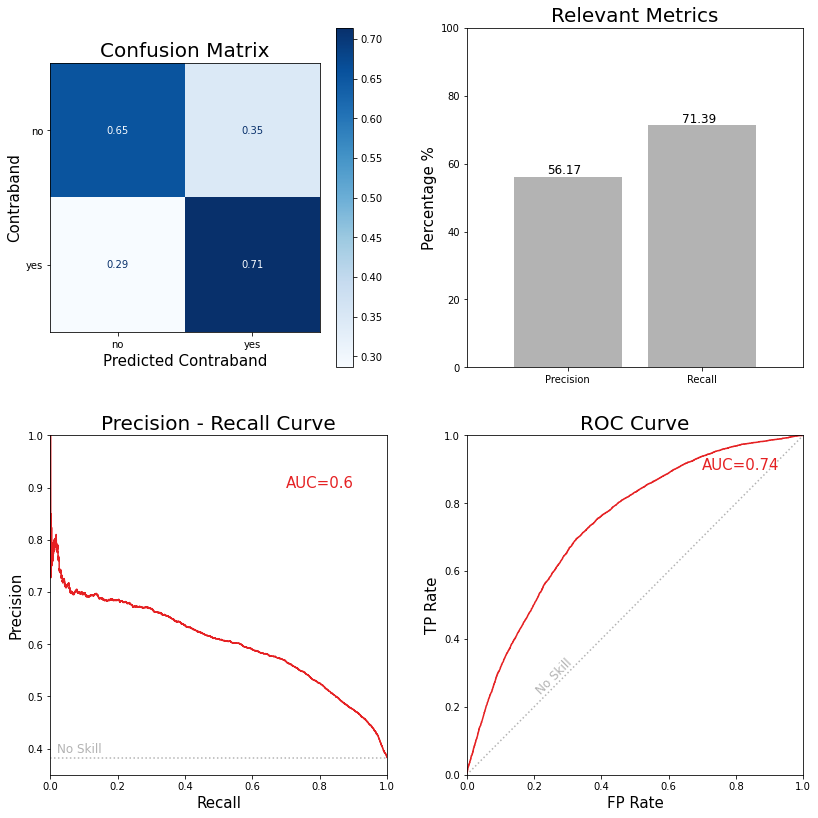

In [6]:
### Calculate and plot model performance

## Calculate Performance metrics

#confusion matrix
conf_mat = confusion_matrix(preds_Df['True_Id'], preds_Df['Preds'])

hits = conf_mat[1,1] # Contrabands correctly predicted
positives = conf_mat[1].sum() # Contrabands on the real data 

f_alarms = conf_mat[0,1] # Contrabands incorrectly predicted
negatives = conf_mat[0].sum() # Non contrabands on real the data


#precision-recall
precision = hits / (hits + f_alarms)
recall = hits / positives


#precision-recall curve
lr_precision, lr_recall, tresh2 = precision_recall_curve(preds_Df['True_Id'], prob_y_0) # Precision recall curve
pr_AUC = auc(lr_recall, lr_precision) # Area under precisition recall curve
pr_no_skill = preds_Df[preds_Df['True_Id']==True].shape[0] / preds_Df['True_Id'].shape[0] # line of no skill for precisition recall curve


#ROC curve
roc_AUC = roc_auc_score(preds_Df['True_Id'], prob_y_0) # ROC auc score
lr_fpr, lr_tpr, tresh1 = roc_curve(preds_Df['True_Id'], prob_y_0) # ROC auc curve



## Plot model performance

#define fig and subplots
fig,axs = plt.subplots(2, 2, figsize=(12,12))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12


#plot confusion matrix
ConfusionMatrixDisplay.from_predictions(preds_Df['True_Id'],preds_Df['Preds'],
                                        ax=axs[0,0],
                                        display_labels=["no", "yes"],
                                        normalize='true',
                                        cmap='Blues')
axs[0,0].set_title('Confusion Matrix',fontsize = t_font)
axs[0,0].set_xlabel('Predicted Contraband',fontsize = l_font)
axs[0,0].set_ylabel('Contraband',fontsize = l_font)


#plot precision and recall for 0.5 probability treshold
y1 = [precision*100, recall*100]
axs[0,1].bar(['Precision', 'Recall'],y1,color=['#B3B3B3'])
axs[0,1].set_ylabel('Percentage %',fontsize = l_font)
axs[0,1].set_title('Relevant Metrics',fontsize = t_font)
axs[0,1].set_ylim([0, 100])
axs[0,1].set_xlim([-0.75, 1.75])

for i, v in enumerate(y1): # place values on top of bars
    axs[0,1].text(i - 0.15, v + 0.8, str(np.round(v,2)),fontsize = txt_font)
    
    
#plot precision-recall curve
axs[1,0].plot(lr_recall,lr_precision,color='#E52123')
axs[1,0].plot([0, 1], [pr_no_skill, pr_no_skill], linestyle=':', label='No Skill', color = '#B3B3B3')
axs[1,0].text(0.02,pr_no_skill+0.01, 'No Skill',fontsize = txt_font, color = '#B3B3B3')
axs[1,0].text(0.7,0.9, 'AUC='+str(np.round(pr_AUC,2)),fontsize = l_font, color = '#E52123')
axs[1,0].set_xlabel('Recall',fontsize = l_font)
axs[1,0].set_ylabel('Precision',fontsize = l_font)
axs[1,0].set_title('Precision - Recall Curve',fontsize = t_font)
axs[1,0].set_ylim([0.35, 1])
axs[1,0].set_xlim([0, 1])


#plot ROC curve
axs[1,1].plot(lr_fpr,lr_tpr,color='#E52123')
axs[1,1].plot([0, 1], [0, 1], linestyle=':', label='No Skill', color = '#B3B3B3')
axs[1,1].text(0.2,0.24, 'No Skill',fontsize = txt_font, color = '#B3B3B3',rotation = 45)
axs[1,1].text(0.7,0.9, 'AUC='+str(np.round(roc_AUC,2)),fontsize = l_font, color = '#E52123')
axs[1,1].set_xlabel('FP Rate',fontsize = l_font)
axs[1,1].set_ylabel('TP Rate',fontsize = l_font)
axs[1,1].set_title('ROC Curve',fontsize = t_font)
axs[1,1].set_ylim([0, 1])
axs[1,1].set_xlim([0, 1])


fig.tight_layout(pad=3.0)

plt.show()    


## Performance Results

Looking at the confusion matrix (top left) we can see that our model correctly classifies 0.71 of the contraband observations (True Positives) and 0.65 of the observations with no contraband (True Negatives). 

The model is well within the initially established requirements. Our objectives were a **precision** and a **recall** of at least 50%, has shown in the top right plot the model acomplished a recall of 71.39% and a precision of 56.17%.

The metrics above are the ones obtained using a probabilities treshold of 0.5 to determine our predictions from the model aasigned probabilities. To get a measure of performance that is not influenced by the choice of treshold we can look at the **Precison-Recall** and **ROC** curves in the bottom plots: both are well above the respective *No Skill* lines. 

By looking at the **Precision-Recall** curve we can also see that by choosing a different treshold we would have been able to obtain different, above 50%, pairs of values for the metrics.

# Model Fairness

Our model seems to fulfill the client's requirement in terms of the amount of contaband uncovered and the searches needed to do so. But the police was also worried about the way the model would treat different protected classes. A difference in precision less or equal than 5%, between protected classe's groups, in each department, was defined as an objective. 


## General fairness

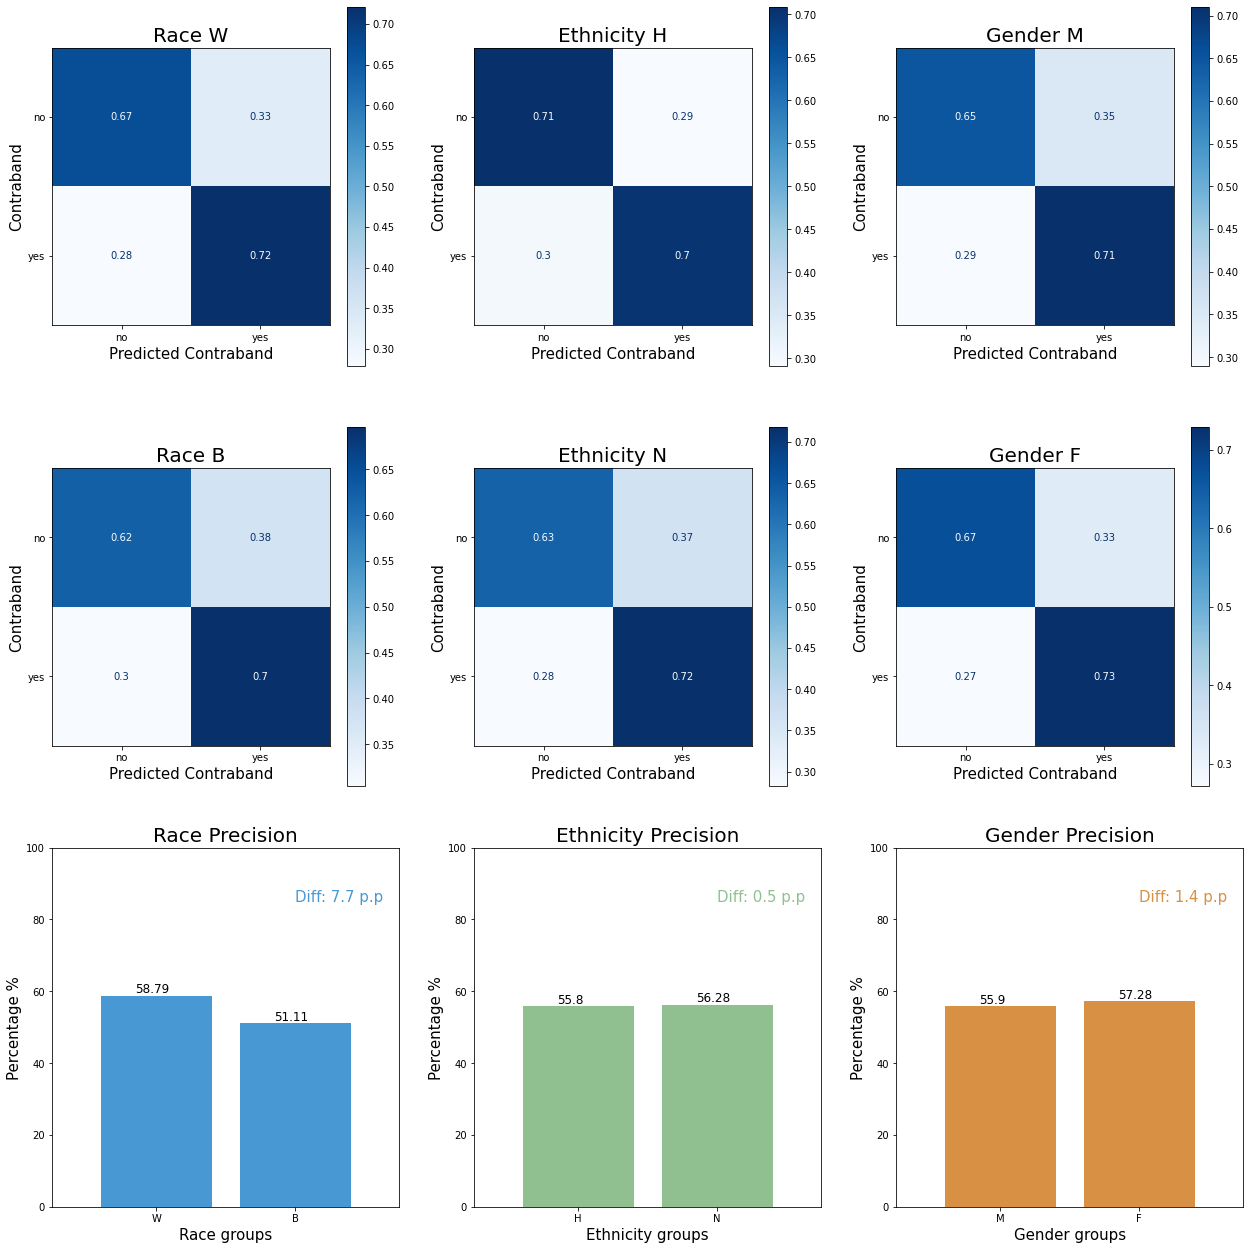

In [7]:
### General bias analysis


#create data frame with relevant data 
df_1 = X_test[['Department Name','Subject Race Code','Subject Ethnicity Code','Subject Sex Code']].reset_index(drop=True)
df_2 = preds_Df.reset_index(drop=True)
bias_df = pd.concat([df_1,df_2],axis = 1)


## Calculate and organize data to plot

#race bias 
races = ['W','B']
r_dict = {}
for r in races:
    r_dict[r] = {}
    f = bias_df['Subject Race Code'] == r
    r_dict[r]['df'] = bias_df.loc[f,['Subject Race Code','Preds','True_Id']]
    conf_mat = confusion_matrix(r_dict[r]['df']['True_Id'], r_dict[r]['df']['Preds'])
    r_dict[r]['hits'] = conf_mat[1,1]
    r_dict[r]['pos'] = conf_mat[1].sum() 
    r_dict[r]['fa'] = conf_mat[0,1] 
    r_dict[r]['neg'] = conf_mat[0].sum()
    r_dict[r]['precision'] = r_dict[r]['hits'] /(r_dict[r]['hits'] + r_dict[r]['fa'])
    
    
#ethnicity bias 
ethnicities = ['H','N']
e_dict = {}
for e in ethnicities:
    e_dict[e] = {}
    f = bias_df['Subject Ethnicity Code'] == e
    e_dict[e]['df'] = bias_df.loc[f,['Subject Ethnicity Code','Preds','True_Id']]
    conf_mat = confusion_matrix(e_dict[e]['df']['True_Id'],e_dict[e]['df']['Preds'])
    e_dict[e]['hits'] = conf_mat[1,1]
    e_dict[e]['pos'] = conf_mat[1].sum() 
    e_dict[e]['fa'] = conf_mat[0,1] 
    e_dict[e]['neg'] = conf_mat[0].sum()
    e_dict[e]['precision'] = e_dict[e]['hits'] /(e_dict[e]['hits'] + e_dict[e]['fa'])
    
    
    
#gender bias 
genders = ['M','F']
g_dict = {}
for g in genders:
    g_dict[g] = {}
    f = bias_df['Subject Sex Code'] == g
    g_dict[g]['df'] = bias_df.loc[f,['Subject Sex Code','Preds','True_Id']]
    conf_mat = confusion_matrix(g_dict[g]['df']['True_Id'], g_dict[g]['df']['Preds'])
    g_dict[g]['hits'] = conf_mat[1,1]
    g_dict[g]['pos'] = conf_mat[1].sum() 
    g_dict[g]['fa'] = conf_mat[0,1] 
    g_dict[g]['neg'] = conf_mat[0].sum()
    g_dict[g]['precision'] = g_dict[g]['hits'] /(g_dict[g]['hits'] + g_dict[g]['fa'])    



## Plot general bias data 

#define fig and subplots
fig,axs = plt.subplots(3, 3, figsize=(18,18))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12


dicts = [r_dict,e_dict,g_dict] # data to plot

#subplot initial indices 
cx = 0
rx = 0

p_groups = ['Race','Ethnicity','Gender'] # plots labels
g_clrs = ['#4899D3','#91C090','#D79044'] # plots colors

for d in dicts:
    #plot confusion matrices
    for r in d.keys():
        
        ConfusionMatrixDisplay.from_predictions(d[r]['df']['True_Id'],d[r]['df']['Preds'],
                                                ax=axs[rx,cx],
                                                display_labels=["no", "yes"],
                                                normalize='true',
                                                cmap='Blues',
                                                colorbar = True)
      
        axs[rx,cx].set_title(p_groups[cx]+' '+ r,fontsize = t_font)
        axs[rx,cx].set_xlabel('Predicted Contraband',fontsize = l_font)
        axs[rx,cx].set_ylabel('Contraband',fontsize = l_font)
        
        #update subplot indices
        if rx == 0:
            rx = 1
        else:
            rx = 0
    
    
    #plot precisions
    g_labels = list(d.keys())
    y1 = [d[g_labels[0]]['precision']*100, d[g_labels[1]]['precision']*100]
    pp_diff = np.round(np.abs(d[g_labels[0]]['precision']*100 - d[g_labels[1]]['precision']*100),1)
    axs[2,cx].bar([g_labels[0], g_labels[1]],y1,color=g_clrs[cx])
    axs[2,cx].text(1, 85, 'Diff: '+str(pp_diff)+' p.p',fontsize = l_font,color=g_clrs[cx])
    axs[2,cx].set_xlabel(p_groups[cx]+' '+'groups',fontsize = l_font)
    axs[2,cx].set_ylabel('Percentage %',fontsize = l_font)
    axs[2,cx].set_title(p_groups[cx]+' '+ 'Precision',fontsize = t_font)
    axs[2,cx].set_ylim([0, 100])
    axs[2,cx].set_xlim([-0.75, 1.75])
          
    for i, v in enumerate(y1): # place values on top of bars
        axs[2,cx].text(i - 0.15, v + 0.8, str(np.round(v,2)),fontsize = txt_font)
    
    #update subplot indices
    cx = cx+1


    
fig.tight_layout(pad=3.0)       
plt.show()



## General fairness results

A glance at the confusion matrices shows us that the results of the model are qualitatively consistent across the different protected classes' groups and also with the general results presented above.

In the bottom plots we can see that that from the three protected classes only in race the different in precision between the two different groupd excedes the 5 p.p., that was our objective, buth not by much. Both it the gender and ethnicity groups the differences are smaller.


## Fairness by department 

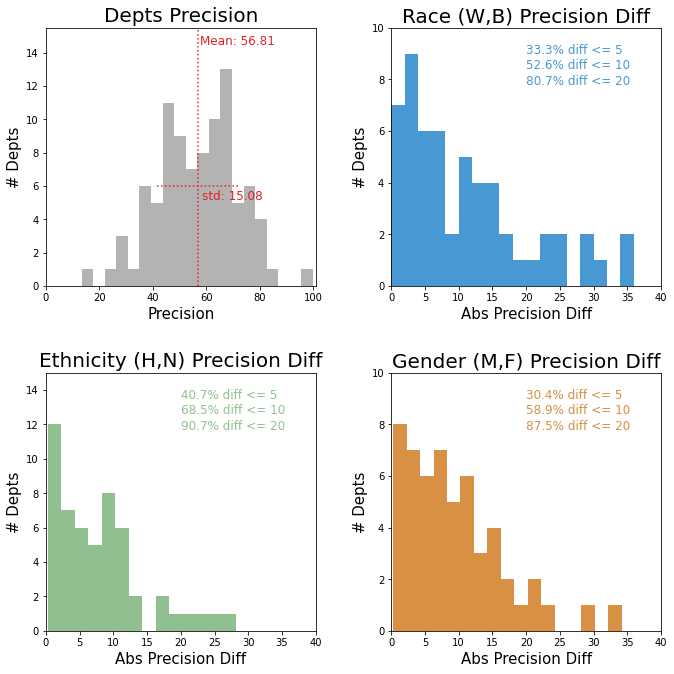

In [8]:
### Calculate and plot precision differences by department


## Calculations

#get dept names 
obs_dpt = bias_df['Department Name'].value_counts()
dpt_names = obs_dpt.keys().tolist()

#only include depts wit #obs above this treshold
obs_tresh = 25 

#df's to store the data
r_precision = pd.DataFrame()
e_precision = pd.DataFrame()
g_precision = pd.DataFrame()
t_precision = pd.DataFrame()

#for each department
for dpt in dpt_names:
    
    #precision per dept
    t_f = bias_df['Department Name'] == dpt
    t_df = bias_df.loc[t_f,['Preds','True_Id']]
    if t_df.shape[0] >= obs_tresh:
        conf_mat = confusion_matrix(t_df['True_Id'],t_df['Preds'])
        t_hits = conf_mat[1,1]
        t_pos = conf_mat[1].sum() 
        t_fa = conf_mat[0,1]
        if t_hits != 0:
            t_precision.loc[dpt,'total'] = (t_hits /(t_hits + t_fa))*100
        else:
            t_precision.loc[dpt,g] = 0
    
    
    
    #race precision per dept
    for r in ['W','B']:
        r_f = (bias_df['Department Name'] == dpt) & (bias_df['Subject Race Code'] == r)
        r_df = bias_df.loc[r_f,['Preds','True_Id']]
        conf_mat = confusion_matrix(r_df['True_Id'],r_df['Preds'])
        if r_df.shape[0] >= obs_tresh:
            r_hits = conf_mat[1,1]
            r_pos = conf_mat[1].sum() 
            r_fa = conf_mat[0,1]
            if r_hits != 0: 
                r_precision.loc[dpt,r] = (r_hits /(r_hits + r_fa))*100
            else:
                r_precision.loc[dpt,r] = 0
    
    r_precision['diff'] = np.abs(r_precision['W'] - r_precision['B'])
    
   
    #ethnicity precision per dept
    for e in ['H','N']:
        e_f = (bias_df['Department Name'] == dpt) & (bias_df['Subject Ethnicity Code'] == e)
        e_df = bias_df.loc[e_f,['Preds','True_Id']]
        conf_mat = confusion_matrix(e_df['True_Id'],e_df['Preds'])
        if e_df.shape[0] >= obs_tresh:
            e_hits = conf_mat[1,1]
            e_pos = conf_mat[1].sum() 
            e_fa = conf_mat[0,1]
            if e_hits != 0:
                e_precision.loc[dpt,e] = (e_hits /(e_hits + e_fa))*100
            else:
                e_precision.loc[dpt,e] = 0
    
    e_precision['diff'] = np.abs(e_precision['H'] - e_precision['N'])
    
    
    #gender precision per dept
    for g in ['M','F']:
        g_f = (bias_df['Department Name'] == dpt) & (bias_df['Subject Sex Code'] == g)
        g_df = bias_df.loc[g_f,['Preds','True_Id']]
        conf_mat = confusion_matrix(g_df['True_Id'],g_df['Preds'])
        if g_df.shape[0] >= obs_tresh:
            g_hits = conf_mat[1,1]
            g_pos = conf_mat[1].sum() 
            g_fa = conf_mat[0,1]
            if g_hits != 0:
                g_precision.loc[dpt,g] = (g_hits /(g_hits + g_fa))*100
            else:
                g_precision.loc[dpt,g] = 0
    
    g_precision['diff'] = np.abs(g_precision['M'] - g_precision['F'])


## Plot precision differences in protected classes
    
#define fig and subplots
fig,axs = plt.subplots(2, 2, figsize=(10,10))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12


#plot precision per department
axs[0,0].hist(t_precision['total'],bins = 20, color=['#B3B3B3'])
tp_mean = t_precision['total'].mean()
tp_std = t_precision['total'].std()
axs[0,0].plot([tp_mean, tp_mean], [0, 15.5], linestyle=':', color =  '#E52123')
axs[0,0].plot([tp_mean - tp_std, tp_mean + tp_std], [6, 6], linestyle=':', color =  '#E52123')

axs[0,0].text(tp_mean+1, 14.5,
              'Mean: '+str(np.round(tp_mean,2)),
              fontsize = txt_font,
              color =  '#E52123')

axs[0,0].text(tp_mean+1.5, 5.2,
              'std: '+str(np.round(tp_std,2)),
              fontsize = txt_font,
              color =  '#E52123')

axs[0,0].set_ylabel('# Depts',fontsize = l_font)
axs[0,0].set_xlabel('Precision',fontsize = l_font)
axs[0,0].set_title('Depts Precision',fontsize = t_font)
axs[0,0].set_ylim([0, 15.5])
axs[0,0].set_xlim([0, 101])





#plot race differences
axs[0,1].hist(r_precision['diff'],bins = 50, color=['#4899D3'])

t_off = 0
for t in [5,10,20]:
    valid_df = r_precision.dropna().copy()
    val = np.round(valid_df.loc[valid_df['diff']<=t,'diff'].shape[0] / valid_df.shape[0]*100,1)
    axs[0,1].text(20, 9-t_off,
              str(val)+'% diff <= '+ str(t),
              fontsize = txt_font,
              color =  '#4899D3')
    t_off = t_off+0.6
    
axs[0,1].set_ylabel('# Depts',fontsize = l_font)
axs[0,1].set_xlabel('Abs Precision Diff',fontsize = l_font)
axs[0,1].set_title('Race (W,B) Precision Diff',fontsize = t_font)
axs[0,1].set_ylim([0, 10])
axs[0,1].set_xlim([0, 40])


#plot ethnicity differences 
axs[1,0].hist(e_precision['diff'],bins = 50, color=['#91C090'])

t_off = 0
for t in [5,10,20]:
    valid_df = e_precision.dropna().copy()
    val = np.round(valid_df.loc[valid_df['diff']<=t,'diff'].shape[0] / valid_df.shape[0]*100,1)
    axs[1,0].text(20, 13.5-t_off,
              str(val)+'% diff <= '+ str(t),
              fontsize = txt_font,
              color =  '#91C090')
    t_off = t_off+0.9
    
axs[1,0].set_ylabel('# Depts',fontsize = l_font)
axs[1,0].set_xlabel('Abs Precision Diff',fontsize = l_font)
axs[1,0].set_title('Ethnicity (H,N) Precision Diff',fontsize = t_font)
axs[1,0].set_ylim([0, 15])
axs[1,0].set_xlim([0, 40])


#plot gender differences 
axs[1,1].hist(g_precision['diff'],bins = 50, color=['#D79044'])

t_off = 0
for t in [5,10,20]:
    valid_df = g_precision.dropna().copy()
    val = np.round(valid_df.loc[valid_df['diff']<=t,'diff'].shape[0] / valid_df.shape[0]*100,1)
    axs[1,1].text(20, 9-t_off,
              str(val)+'% diff <= '+ str(t),
              fontsize = txt_font,
              color =  '#D79044')
    t_off = t_off+0.6
    
axs[1,1].set_ylabel('# Depts',fontsize = l_font)
axs[1,1].set_xlabel('Abs Precision Diff',fontsize = l_font)
axs[1,1].set_title('Gender (M,F) Precision Diff',fontsize = t_font)
axs[1,1].set_ylim([0, 10])
axs[1,1].set_xlim([0, 40])


fig.tight_layout(pad=3.0)       
plt.show()




    

## Fairness by department results

The first important observation is that there is a considerable variability in overall precision per department (top left), std = 15.08.

The second is that the objective of keeping the groups of all protected classes within a 5 p.p precision, in all departments, was not acomplished. As can be seen above, in all classes, roughly more than thirty, fifty and eighty percent of the departmens have their groups within a 5, 10 and 20 percentage points margin. Remember that this is without feeding the model with any explicit information about the protected classes.

To deal with such we tried several resampling strategies, both at the global and department level, so that the different groups of the protected classes had the same number of observarions with and without contraband in the training set. None of these were successful, with the impact on the difference of precision between groups being minimal, and we decided not to implement them in the final version of the model. 

We didn't include in these analysis departments with less than 25 observations.  

# Feature importance

One of the reasons for which we decided to use a logistic regression model was its interpretability. We can use the coefficients attributed to each predictive feature to know its importance in the ability of the model to make predictions. In our case this can be done directly because, being one hot encoded, all features were in the same units scale.

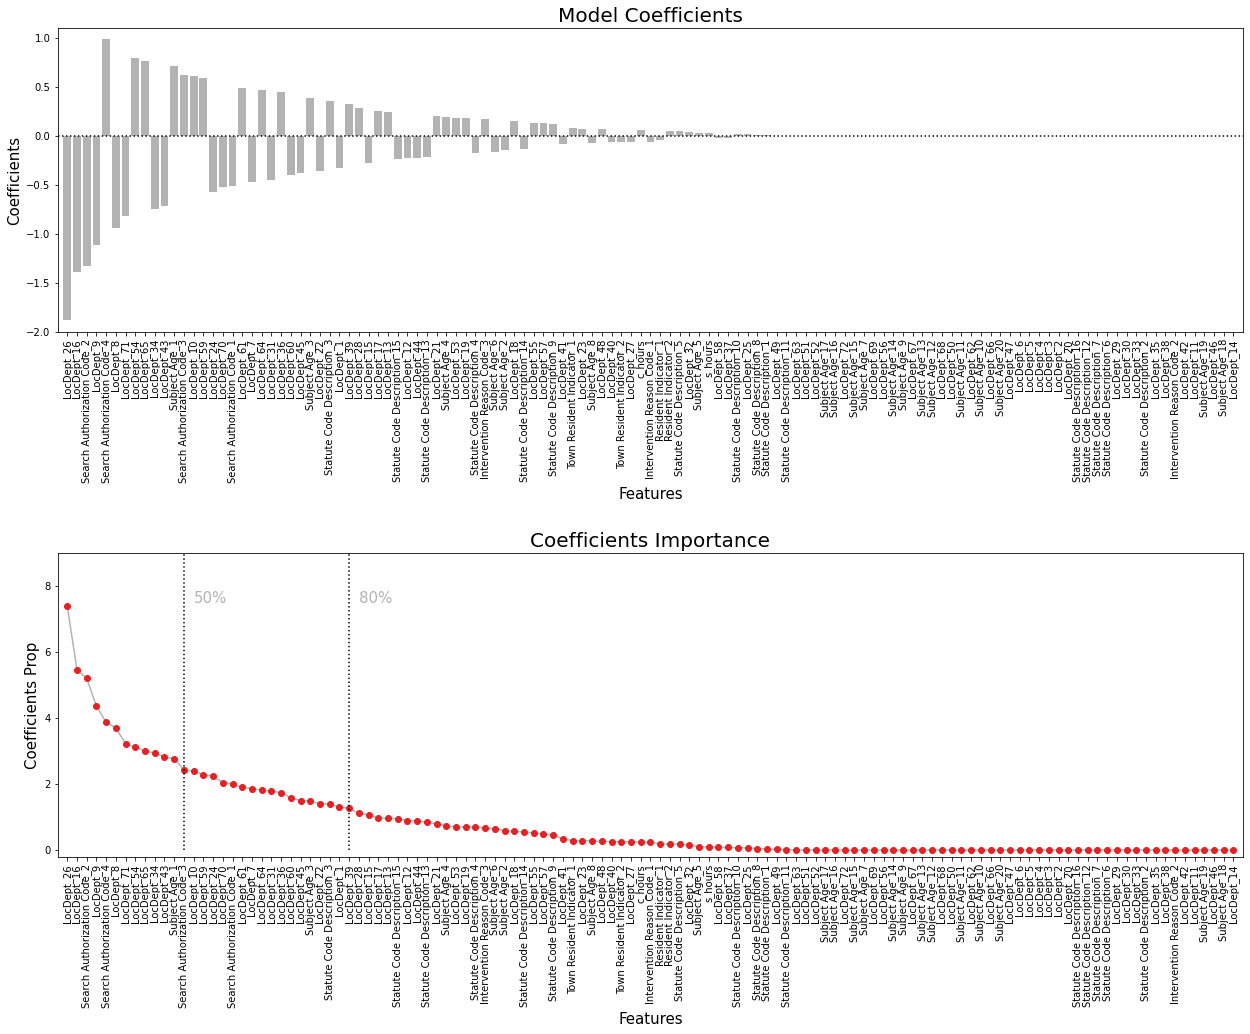

In [9]:
### Plot features' coefficients

## Get coefs

#coefs for best estimator
coefs = pipeline[-1].best_estimator_.coef_[0]
#coefs names
feat_names = pipeline[-1].best_estimator_.feature_names_in_

#sorted coefs and names
sorting_order = np.argsort(np.abs(coefs)*-1)
sorted_coefs = coefs[sorting_order] # Sorted Coefs
sorted_names = feat_names[sorting_order] # Sorted feature names

#coefs relative weight
prop_coefs = (np.abs(sorted_coefs) / np.abs(sorted_coefs).sum()) * 100
tresh_coef_idx_80 = np.where(prop_coefs.cumsum()>=80)[0][0] 
tresh_coef_name_80 = sorted_names[tresh_coef_idx_80]
tresh_coef_idx_50 = np.where(prop_coefs.cumsum()>=50)[0][0] 
tresh_coef_name_50 = sorted_names[tresh_coef_idx_50]


## Plot coefs

#define fig and subplots
fig,axs = plt.subplots(2, 1, figsize=(18,15))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12

#plot coefs values
axs[0].bar(sorted_names,sorted_coefs,color=['#B3B3B3'])
axs[0].plot([-1,121], [0, 0], linestyle=':', color =  'k')
axs[0].set_ylabel('Coefficients',fontsize = l_font)
axs[0].set_xlabel('Features',fontsize = l_font)
axs[0].set_title('Model Coefficients',fontsize = t_font)
axs[0].set_ylim([-2, 1.1])
axs[0].set_xlim([-1, 121])
axs[0].set_xticklabels(sorted_names, rotation=90)


#plot feature's importance
axs[1].plot(sorted_names,prop_coefs,Marker = 'o',color='#B3B3B3',
            markerfacecolor = '#E52123',markeredgecolor = '#E52123')

axs[1].plot([tresh_coef_idx_80, tresh_coef_idx_80], [0, 9], linestyle=':', color =  'k')
axs[1].text(tresh_coef_idx_80+1, 7.5,
              '80%',
              fontsize = l_font,
              color =  '#B3B3B3')

axs[1].plot([tresh_coef_idx_50, tresh_coef_idx_50], [0, 9], linestyle=':', color =  'k')
axs[1].text(tresh_coef_idx_50+1, 7.5,
              '50%',
              fontsize = l_font,
              color =  '#B3B3B3')

axs[1].set_ylabel('Coefficients Prop',fontsize = l_font)
axs[1].set_xlabel('Features',fontsize = l_font)
axs[1].set_title('Coefficients Importance',fontsize = t_font)
axs[1].set_ylim([-0.2, 9])
axs[1].set_xlim([-1, 121])
axs[1].set_xticklabels(sorted_names, rotation=90)

fig.tight_layout(pad=3.0)       
plt.show()


## Feature importance results

The first thing to notice is that the importance of the features is quite distributed, there's no feature or small group of features responsible for the entire predictive power of the model. The most important feature represents less than 8% of the sum of all coefficients and we need 13 and 29 features to explain 50 and 80% of the total variance, respectively (bottom plot).

Going back to the original features one can see that the model is mainly taking advantage of location information ('LocDept'), the code provided for the search authorization ('Search Authorization Code') and the age of the subjects ('Subject Age'). In the top plot we can also see how different features (e.g. different departmens or different search authorization codes) have coefficients with different signs, indicating their direct or inverse relation with the presence of contraband.

For descriptive purposes, below are the features that explain 50% of the total variance and the respective sign of the coefficients:<br>

   . Wilton dept (-)<br>
   . Brandford dept (-)<br>
   . Search Authorization Code I (-)<br>
   . Bridgeport dept (-)<br>
   . Search Authorization Code N (+)<br>
   . Danbury dept(-)<br>
   . West Haven dept (-)<br>
   . Southington dept (+)<br>
   . Vernon dept (+)<br>
   . New Haven dept (-)<br>
   . StatePolice-Waterbury loc-dept (-)<br>
   . Subject Age 15-20(+)<br>
   . Search Authorization Code O (+)<br>

# Final Observations 

The model was fitted in this particular data set and reflects its characteristics. Measures were taken to avoid overfitting (e.g. use of regularization and regularization paramaters set by cross-validation) to guarantee that it would generalize to unseen data (e.g. performance evaluated on held-out data), but these don't totally guarantee that the model will behave in the same way when deployed in a real world scenario. If the context from which new observations are collected is very different from the one where the model was fitted its assumptions might not hold.   


Our model relies on a relatively small number of original features, a lot of them connected to the location of the intervention and the department responsible for it. If there's change (social, political, etc.) that alters the geographical pattern of contaband occurreces within the state that would probably harm the model performance. Beaurocratic changes in the nomenclatures used for departments, resasons and codes or changes in the areas that the different sub-departments are responsible for would also be problematic.  


Finally, our model was fitted to observations in which vehicles were searched by the police. The service we are being asked for should confirm, or not, that search decision. The fact that, from now on, the police officers know that they can always recur to the service to make a search decisions might loosen their search criterion ( avoiding this responsibility and passing it to us ) changing the underlying data patterns that our model was fitted on.